# Workspace \#10: Parameter Space

In [3]:
# getting future division
from __future__ import division

# autoreloading for imported modules
%load_ext autoreload
%autoreload 2

# numpy
import numpy as np
from numpy import pi, sqrt, log, log10, power, exp

#scipy
from scipy.interpolate import interp1d

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import ticker
from matplotlib.lines import Line2D

# other
import os
from tqdm import tqdm

# matplotlib style
%matplotlib inline

%config InlineBackend.figure_format = "retina"
rcParams['figure.figsize'] = (13, 8)
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['New Times Roman']
rc('text', usetex=True)

# current directory
current_dir = os.getcwd()

In [4]:
from random import random, choice

import sys
sys.path.insert(0, '../')

import tools as tl
import constants as ct
import particle as pt
import ska as sk
import astro as ap
import echo as ec
import routines as rt
import data as dt
import model as md
import green as gr

In [5]:
# Important quantities for aberration estimate
solar_period = 2.4e8 # [years]
solar_mw_radius = ct._Sun_to_gal_center_ # [kpc]

## 1. Loading other axion limits

In [6]:
sys.path.insert(0, '../axion_limits/')
from PlotFuncs_mod import AxionPhoton
plt.rcParams['axes.linewidth'] = 1.
plt.rc('font', family='serif',size=25)

In [7]:
def gen_constraints(show_bounds=True):
    fig, ax = plt.subplots(figsize=(10,10))
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(1.5e-12, 1e-9)
    plt.xlim(1e-7, 1e-3)
    plt.xlabel(r'$m_a$ [eV]')
    plt.ylabel(r'$g_{a\gamma}$ [GeV$^{-1}$]')

    fs = 20 # fontsize
    text_on = True
    projection = False

    if show_bounds:
    # AxionPhoton.Haloscopes(ax)
    # hand-pick those from Haloscopes 
    # the references are here: 
    # https://github.com/cajohare/AxionLimits/tree/master/refs
        AxionPhoton.ADMX(ax,projection=projection,fs=fs,text_on=text_on, col=[0.8, 0.8, 0.8], text_shift=[1.7, 0.6e2])
        AxionPhoton.RBF_UF(ax,fs=fs-2,text_on=text_on, col=[0.8, 0.8, 0.8], text_shift=[1.1, 1.5])
        AxionPhoton.HAYSTAC(ax,projection=projection,text_on=text_on, col=[0.8, 0.8, 0.8], fs=13, text_shift=[0.8, 15])
        AxionPhoton.CAPP(ax,fs=fs-4,text_on=text_on, col=[0.4, 0.4, 0.4], text_shift=[1.1,400])
        AxionPhoton.ORGAN(ax,projection=projection,text_on=text_on, col=[0.8, 0.8, 0.8], fs=15, text_shift=[1,0.6])
        AxionPhoton.ADMX_SLIC(ax,fs=fs-8,text_on=text_on, col=[0.8, 0.8, 0.8], text_shift=[0.6,1])
        AxionPhoton.QUAX(ax,text_on=text_on, text_shift=[0.8, 0.5], col=[0.8, 0.8, 0.8])
        AxionPhoton.Helioscopes(ax, text_shift=[3e-2, 0.9], col=[0.6, 0.6, 0.6])
        AxionPhoton.NeutronStars(ax, fs=fs, text_shift=[6,0.15], col=[0.6, 0.6, 0.6])
    #plt.tight_layout()
    ax.tick_params("both", which="both", labelsize=fs, direction="in", length=10.) # larger ticks, pointing inwards for easier reading

    return fig, ax

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe891684ed0>)

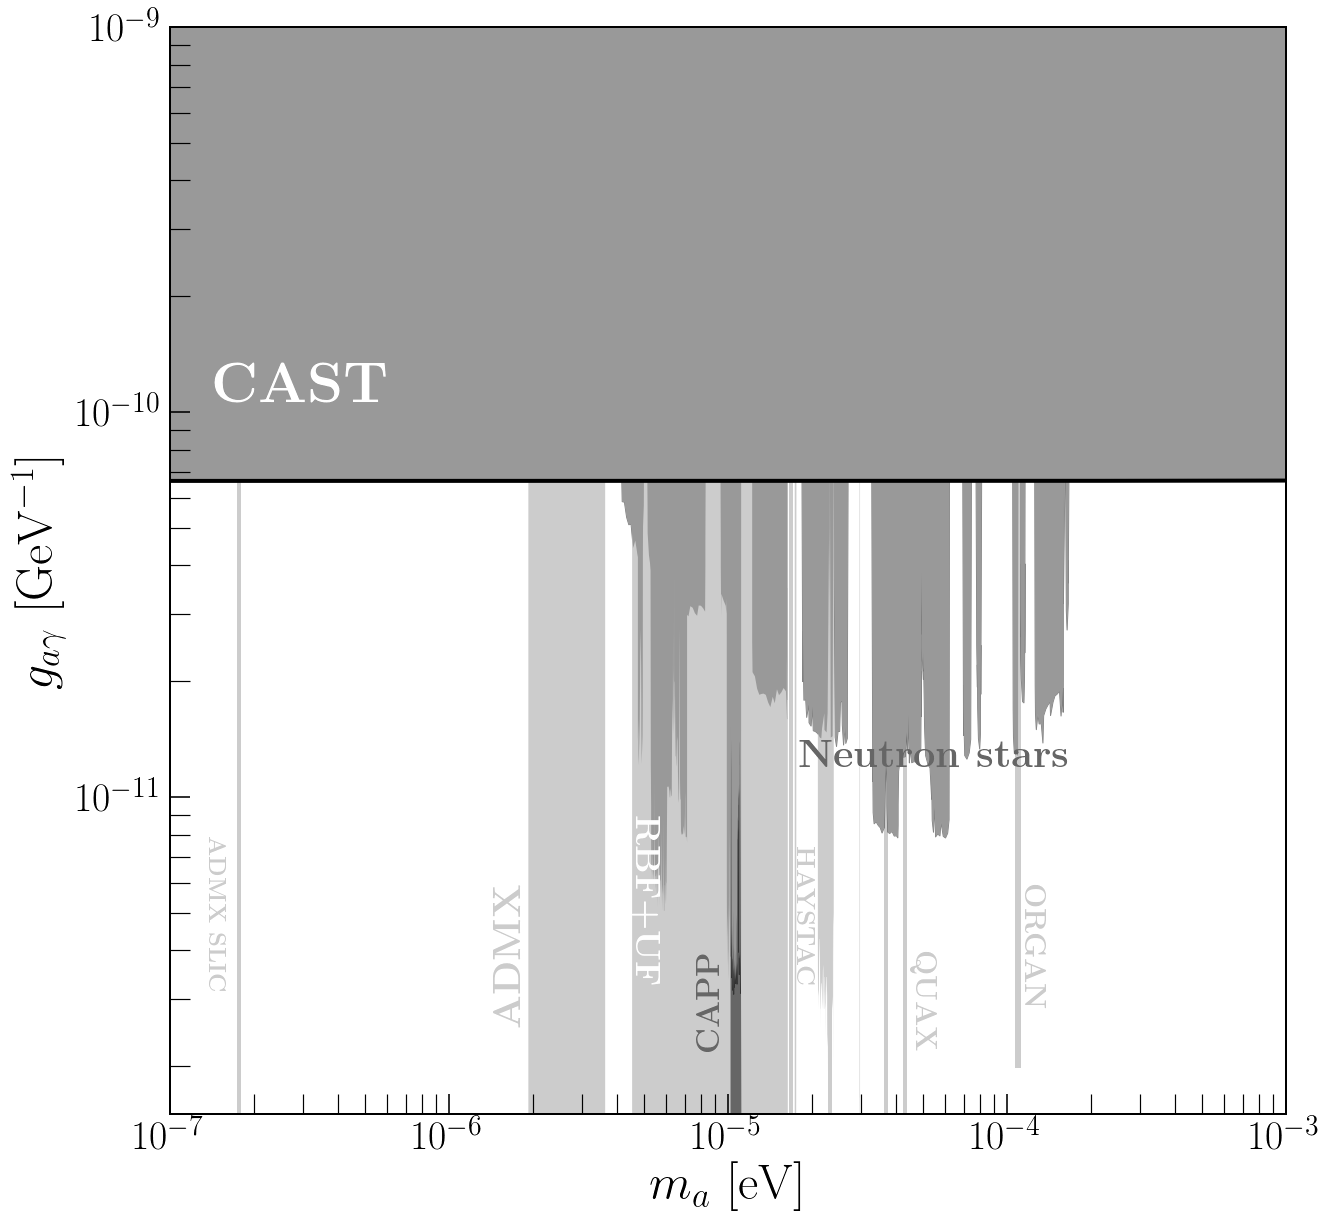

In [8]:
gen_constraints()

## 2. Loading Green's Catalog Results

In [25]:
CasA = 'G111.7-2.1'
W28 = 'G6.4-0.1'
W50 = 'G39.7-2.0'
Kepler = 'G4.5+6.8'
Crab = 'G184.6−5.8'
Vela = 'G263.9−3.3'
SgrAEast = 'G0.0+0.0'

In [10]:
help(gr.load_green_results)

Help on function load_green_results in module green:

load_green_results(name, run_id=None)
    Function that loads the numerical results for the SNRs from Green's Catalog.



In [12]:
ma_ga_reach = {}
for run_id in tqdm(range(1,25)):
    
    ma_ga_reach[run_id] = {}
    
    for name in dt.snrs_cut.keys():
        
        try:
            _, ma, res = gr.load_green_results(name, run_id=run_id)
        except:
            continue
        
        ma_ga_reach[run_id][name] = np.vstack((ma, res['ga'])).T


# repeating the process, but for some special runs
for run_id in tqdm([101, 102]):
    
    ma_ga_reach[run_id] = {}
    
    for name in dt.snrs_cut.keys():
        
        try:
            _, ma, res = gr.load_green_results(name, run_id=run_id)
        except:
            continue
        
        ma_ga_reach[run_id][name] = np.vstack((ma, res['ga'])).T

100%|██████████| 2/2 [00:00<00:00,  9.23it/s]


In [19]:
runs_mins = {}
for run_id in range(1, 25):
    reach = ma_ga_reach[run_id]
    try:
        tmp = {name:min(maga[:,1]) for name, maga in reach.items()}
        min_name = min(tmp, key=tmp.__getitem__)
        runs_mins[run_id] = min_name, min(reach[min_name][:,1])
    except:
        continue

In [21]:
runs_mins

{1: ('G39.7-2.0', 1.6826987651814937e-11),
 2: ('G39.7-2.0', 2.766748950039305e-11),
 3: ('G114.3+0.3', 3.4112991926472396e-10),
 4: ('G65.3+5.7', 8.976571746867748e-12),
 5: ('G65.3+5.7', 3.782649102235124e-11),
 6: ('G39.7-2.0', 8.973354305359276e-12),
 7: ('G39.7-2.0', 6.219239812585329e-12),
 8: ('G39.7-2.0', 1.0225879746014533e-11),
 9: ('G114.3+0.3', 1.6752281895264258e-10),
 10: ('G119.5+10.2', 4.814748056667808e-12),
 11: ('G119.5+10.2', 2.021160328951581e-11),
 12: ('G39.7-2.0', 3.316543846295926e-12)}

## 3. Plots

### 3.1 $(m_a, g_{a\gamma\gamma})$

In [38]:
def ma_ga_arr(snr_name, sd_run, if_run):
    
    lines, ma, sd_res = gr.load_green_results(snr_name, run_id=sd_run)
    _, _, if_res = gr.load_green_results(snr_name, run_id=if_run)
    
    try:
        Lpk_idx = [('L_peak:' in line) for line in lines].index(True)
        Lpk = float(lines[Lpk_idx].split()[-1])
        
        tpk_idx = [('t_peak:' in line) for line in lines].index(True)
        tpk = float(lines[tpk_idx].split()[-1])
        
        extra = Lpk, tpk
        
    except:
        
        ttr_idx = [('t_trans:' in line) for line in lines].index(True)
        ttr = float(lines[ttr_idx].split()[-1])
    
        extra = ttr
    
    ma_ga = np.vstack((ma, np.minimum.reduce((sd_res['ga'], if_res['ga'])))).T
    
    return ma_ga, extra

In [39]:
ma_ga_arr(W50, 2, 8)

(array([[4.30321005e-07, 1.59760975e-11],
        [4.47753969e-07, 1.47828720e-11],
        [4.65893170e-07, 1.38636502e-11],
        [4.84767217e-07, 1.31362812e-11],
        [5.04405880e-07, 1.25509570e-11],
        [5.24840137e-07, 1.20805027e-11],
        [5.46102216e-07, 1.16978862e-11],
        [5.68225654e-07, 1.13921979e-11],
        [5.91245347e-07, 1.11701311e-11],
        [6.15197603e-07, 1.10100634e-11],
        [6.40120202e-07, 1.08762627e-11],
        [6.66052454e-07, 1.07392262e-11],
        [6.93035260e-07, 1.04908082e-11],
        [7.21111182e-07, 1.03015085e-11],
        [7.50324502e-07, 1.02258797e-11],
        [7.80721299e-07, 1.03260572e-11],
        [8.12349517e-07, 1.05170904e-11],
        [8.45259042e-07, 1.07877428e-11],
        [8.79501782e-07, 1.11200034e-11],
        [9.15131749e-07, 1.14799060e-11],
        [9.52205140e-07, 1.18138337e-11],
        [9.90780431e-07, 1.21596979e-11],
        [1.03091847e-06, 1.25524767e-11],
        [1.07268255e-06, 1.2943132

In [40]:
def float_exp(num):
    
    dex = int(np.floor(log10(num)))
    lead = 10.**(log10(num)-dex)
    
    if lead == 1.:
        return r"$10^{%d}$" % dex
    else:
        return r"$%.1f \times 10^{%d}$" % (lead, dex)
    
    return lead, dex

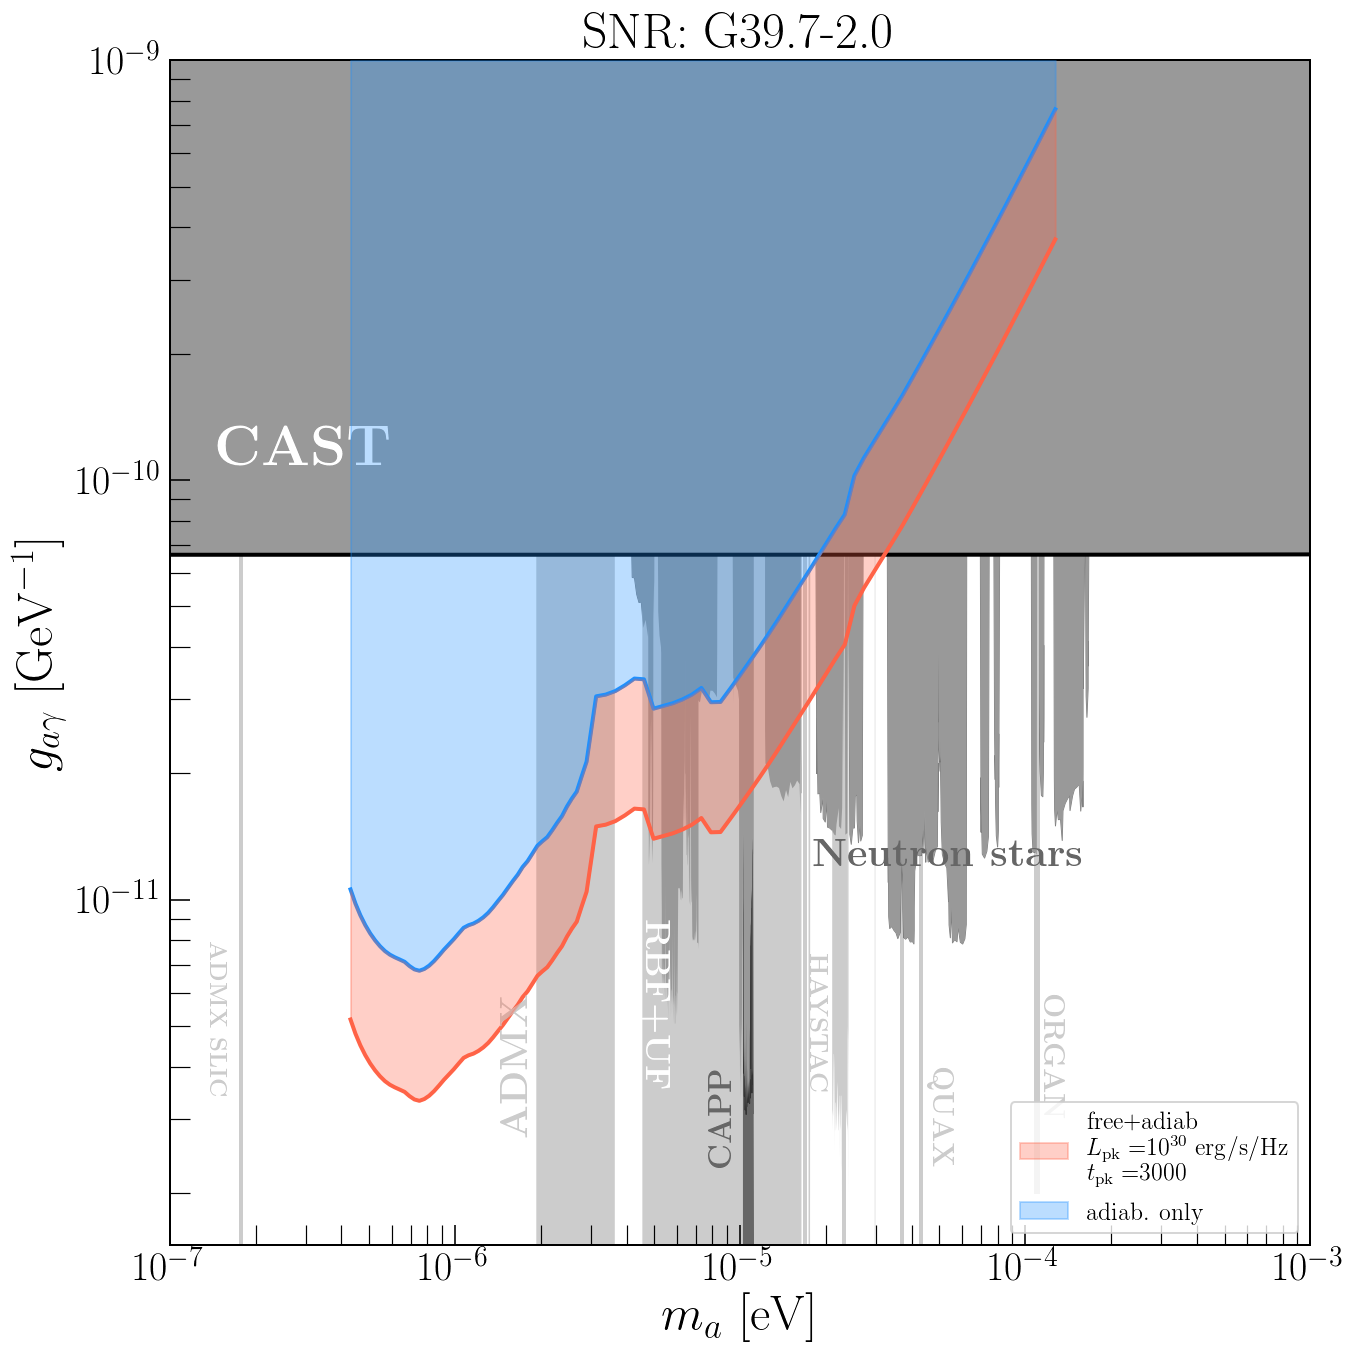

In [69]:
# whether we want to zoom the plot
zoomed = False

name = W50

# runs for adiabatic only, t_trans = 300
# ad_sd_run, ad_if_run = 2, 8

# runs for adiabatic only, t_trans = 121
ad_sd_run, ad_if_run = 101, 102

# reach for adiabatic only:
ad_reach, ttr = ma_ga_arr(name, ad_sd_run, ad_if_run)

# runs for free+adiabatic, t_trans = 121
fa_sd_run, fa_if_run = 6, 12
fa_reach, pars = ma_ga_arr(name, fa_sd_run, fa_if_run)
Lpk, tpk = pars

fix, ax = gen_constraints()

ax.loglog(fa_reach[:,0], fa_reach[:,1], lw=2., color="tomato")
ax.fill_between(fa_reach[:,0], fa_reach[:,1], ad_reach[:,1], alpha=0.3, color="tomato", zorder=50, label="free+adiab\n"+r"$L_{\rm pk} = $"+float_exp(Lpk)+r" $\mathrm{erg/s/Hz}$"+"\n"+r"$t_{\rm pk} = $"+"{}".format(int(tpk)))

ax.loglog(ad_reach[:,0], ad_reach[:,1], lw=2., color="dodgerblue")
ax.fill_between(ad_reach[:,0], ad_reach[:,1], 1.e-9, alpha=0.3, color="dodgerblue", zorder=50, label="adiab. only")

if zoomed:
    ax.set_xlim(3.e-7, 1.e-4)
    ax.set_ylim(1.e-12, 1.e-9)

ax.legend(fontsize=12, loc="lower right");
ax.set_title("SNR: %s" % name, fontsize=25);

plt.tight_layout()

file_name = "ma_ga_reach_%s.pdf" % name.replace(".", "")
plt.savefig("plots/"+file_name, bbox_inches="tight")

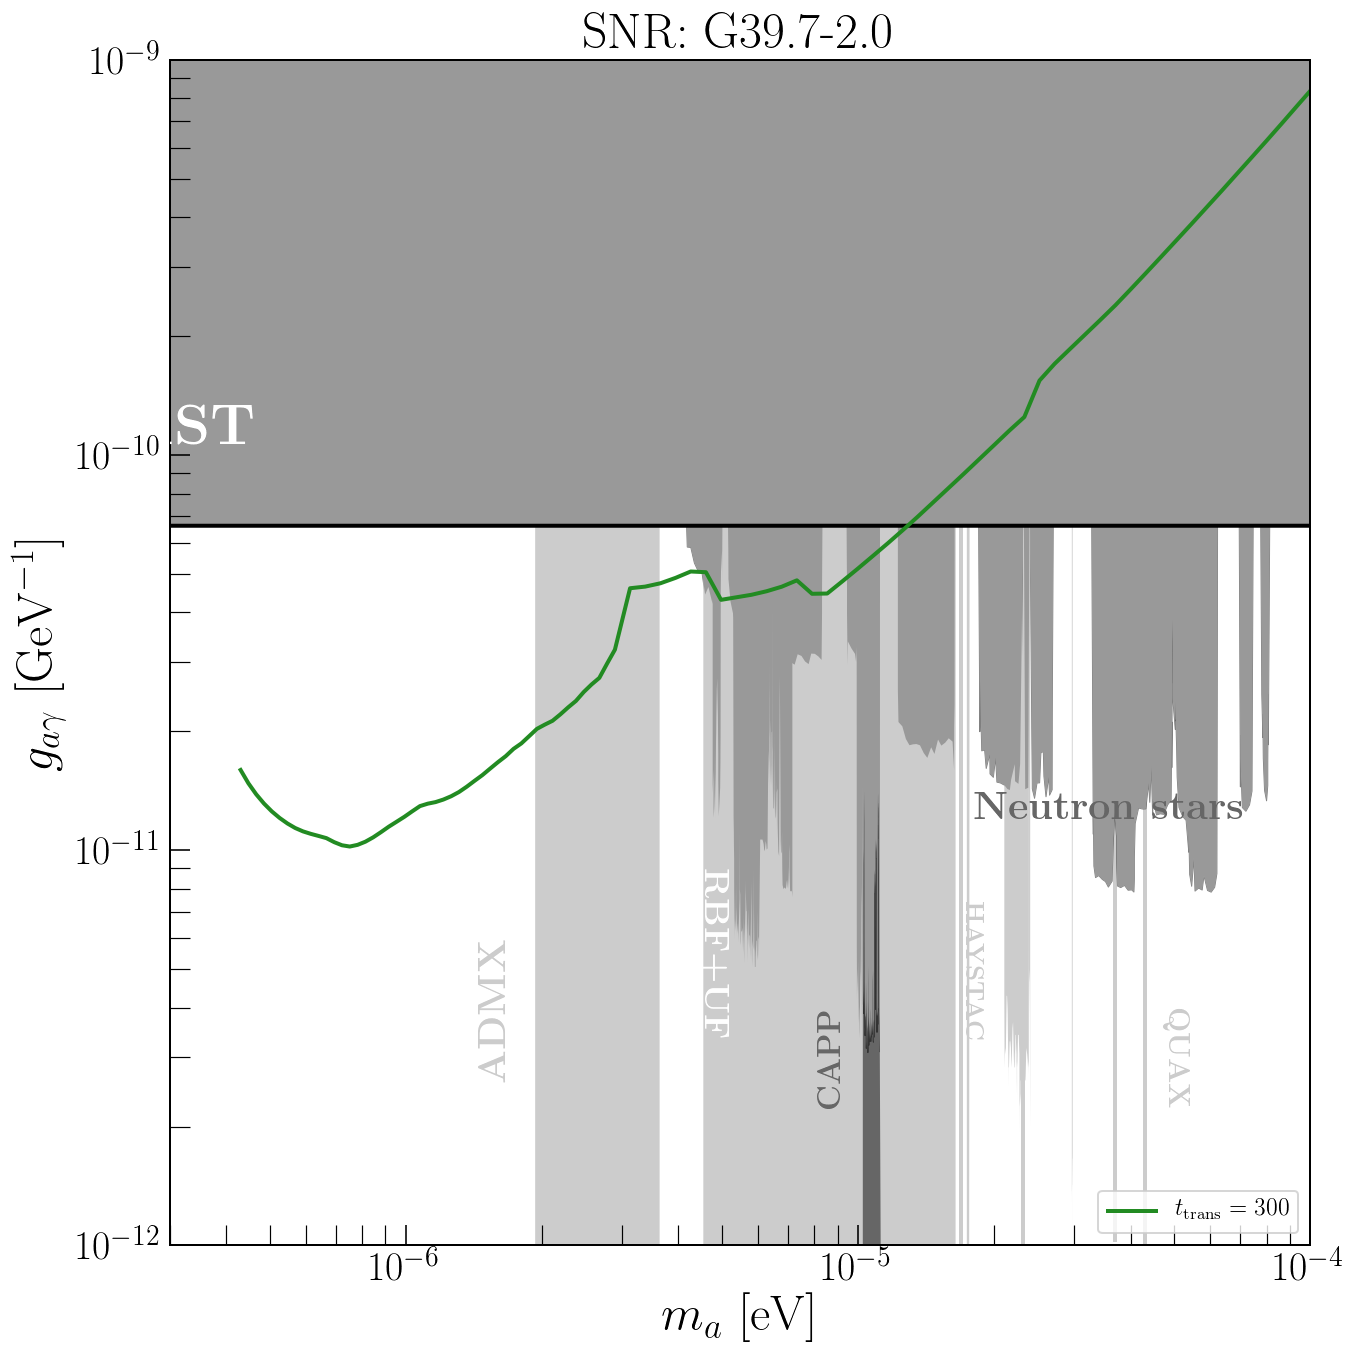

In [75]:
# whether we want to zoom the plot
zoomed = True

name = W50

# runs for adiabatic only, t_trans = 300
ad_sd_run, ad_if_run = 2, 8

# reach for adiabatic only:
ad_reach, ttr = ma_ga_arr(name, ad_sd_run, ad_if_run)

fix, ax = gen_constraints()

ax.loglog(ad_reach[:,0], ad_reach[:,1], lw=2., color="forestgreen", label=r"$t_{\rm trans} = %.0f$" % ttr)

if zoomed:
    ax.set_xlim(3.e-7, 1.e-4)
    ax.set_ylim(1.e-12, 1.e-9)

ax.legend(fontsize=12, loc="lower right");
ax.set_title("SNR: %s" % name, fontsize=25);

plt.tight_layout()

file_name = "compare_reach_%s.pdf" % name.replace(".", "")
plt.savefig("plots/"+file_name, bbox_inches="tight")

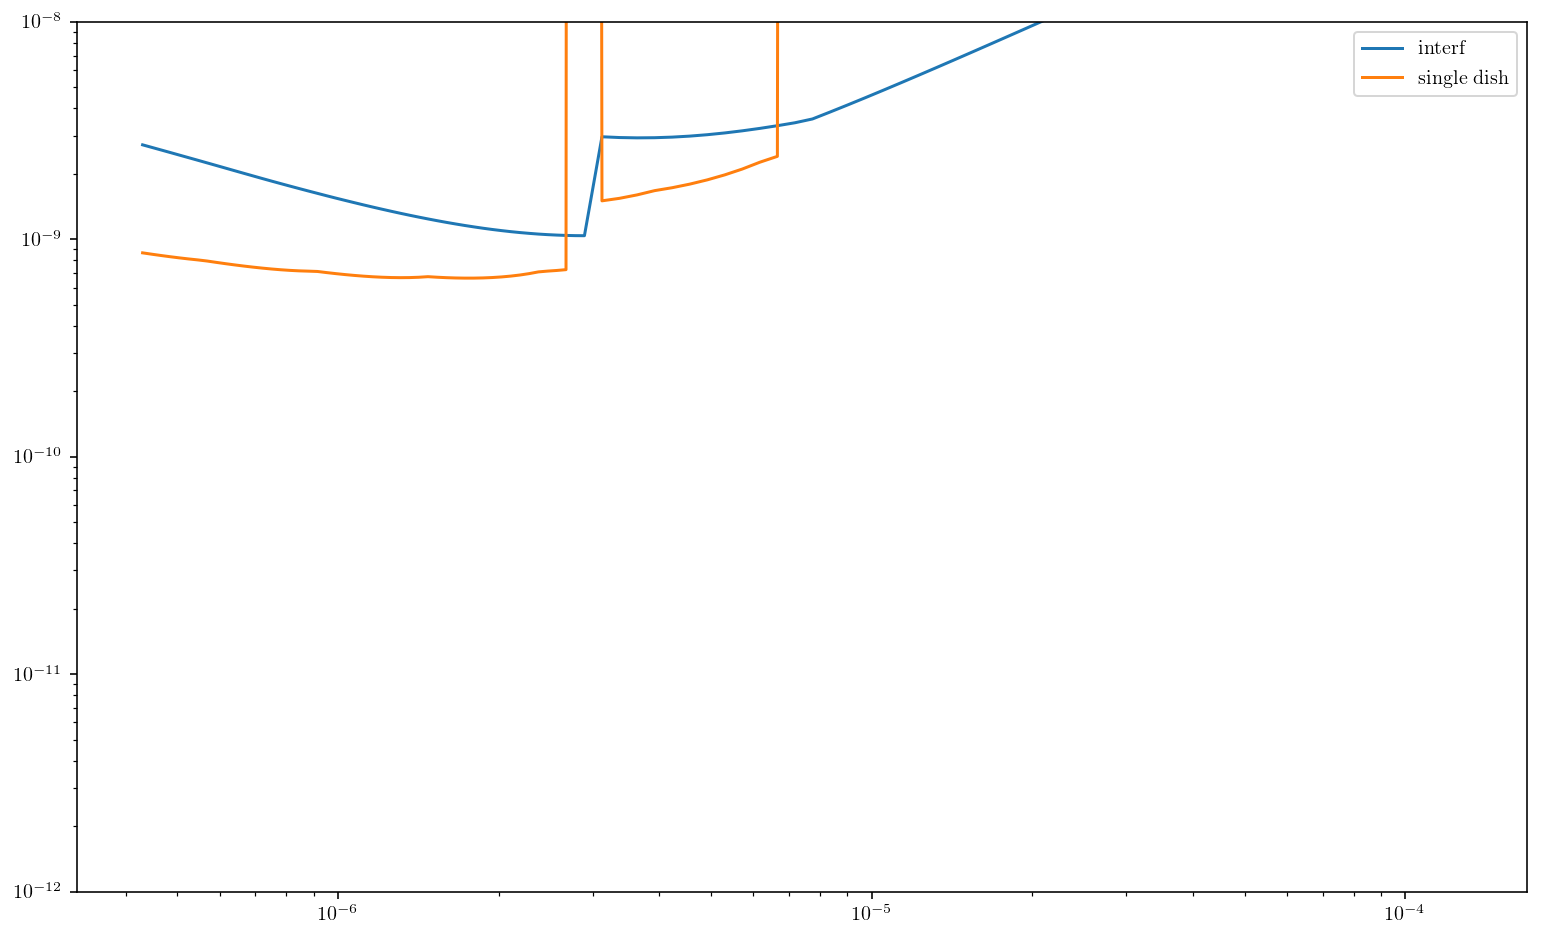

In [106]:
name = 'G39.7-2.0' # W50
# name = 'G78.2+2.1' # seemingly, our best SNR

ma_ga = ma_ga_reach[1][name]
plt.loglog(ma_ga[:,0], ma_ga[:,1], label="interf")
ma_ga = ma_ga_reach[3][name]
plt.loglog(ma_ga[:,0], ma_ga[:,1], label="single dish")
plt.ylim(1.e-12, 1.e-8);

plt.legend();

### TODO: allow for ``r==None``, i.e., for SNRs with known age.

In [14]:
# SNR properties
r = 30.
tex = 0.
nuB = 8.

# axion parameters
ga_ref = 1.e-10
nu_pivot = 1.
ma_ref = pt.ma_from_nu(nu_pivot)

# reach:
sn_th = 2.
sigs_th = 2.
out_sigs = (gr.sigs_Gr > sigs_th)

min_ga = {}
min_ga_sigs = {}
pars_sigs = {}
for name, snr in tqdm(gr.snrs_cut.items()):
    
    sn_Gr, echo_Gr, time_Gr =  gr.load_green_results(name, r=r, tex=tex, nuB=nuB)

    _, ga_Gr, _, _, no_Gr = gr.snr_reach(name,
                                         r=r,
                                         nuB=nuB,
                                         tex=tex,
                                         sn_ratio_threshold=sn_th,
                                         full_output=True)
    # minimum ga
    min_ga[name] = ga_Gr.min()
    
    # minimum ga within sigmas threshold
    ga_within = np.ma.masked_array(ga_Gr, mask=out_sigs)
    ga_lowest_idx = ga_within.argmin()
    ga_lowest = (ga_Gr.flatten())[ga_lowest_idx]
    
    min_ga_sigs[name] = ga_lowest
    pars_sigs[name] = {'tpk':(gr.pre_tpk_Gr.flatten())[ga_lowest_idx],
                       'Lpk':(gr.pre_Lpk_Gr.flatten())[ga_lowest_idx]}

100%|██████████| 61/61 [00:20<00:00,  2.92it/s]


In [15]:
min_key = min(min_ga, key=min_ga.__getitem__)
print("Absolute smallest ga in SNR: \n{}, ga = {}".format(min_key, min_ga[min_key]))

min_sigs_key = min(min_ga_sigs, key=min_ga_sigs.__getitem__)
print("\nSmallest ga within {}-sigmas in SNR:\n{}, ga = {}".format(int(sigs_th), min_sigs_key, min_ga_sigs[min_sigs_key]))
print("\tCorresponding parameters: {}".format(pars_sigs[min_sigs_key]))

Absolute smallest ga in SNR: 
G111.7-2.1, ga = 6.23870860303e-12

Smallest ga within 2-sigmas in SNR:
G4.5+6.8, ga = 1.77149109363e-10
	Corresponding parameters: {'Lpk': 1.1874815363065927e+28, 'tpk': 414.95404263436325}


In [23]:
sorted_keys = sorted(min_ga, key=min_ga.__getitem__)
sorted_sigs_keys = sorted(min_ga, key=min_ga_sigs.__getitem__)

# [min_ga_sigs[key] for key in sorted_sigs_keys]

In [26]:
print(sorted_sigs_keys[0] == min_sigs_key)
print(sorted_keys[0] == min_key)

True
True


In [67]:
# Exploring results:

# name = sorted_keys[0]
name = sorted_sigs_keys[1]
snr = gr.snrs_cut[name]

print(name)

NL, Nt = -3., 0

Lpk = 10.**(ct._mu_log10_Lpk_ + NL*ct._sig_log10_Lpk_)
tpk = 10.**(ct._mu_log10_tpk_ + Nt*ct._sig_log10_tpk_)

L0 = snr.get_luminosity()
gamma = ap.gamma_from_alpha(snr.alpha)
from_Bieten_to_pivot = (nu_pivot/nuB)**-snr.alpha
new_Lpk = Lpk*from_Bieten_to_pivot

lightcurve_params = {'t_peak': tpk,
                     'L_peak': new_Lpk,
                     'L_today': L0}
t_trans = r*(lightcurve_params['t_peak']/365.)
lightcurve_params.update({'t_trans':t_trans})

t_age = ap.tage_compute(new_Lpk, tpk, t_trans, L0, gamma)

age_steps = abs(int(1000.*(log10(t_age) - log10(tpk/365.)) + 1))
max_steps = 100001
snu_echo_kwargs = {'tmin_default': None,
                   'Nt': min(age_steps, max_steps),
                   'xmin': ct._au_over_kpc_,
                   'xmax_default': 100.,
                   'use_quad': False,
                   'lin_space': False,
                   'Nint': min(age_steps, max_steps),
                   't_extra_old': tex}
            
# data:
data = {'deltaE_over_E': 1.e-3,
        'f_Delta': 0.721,
        'exper': 'SKA',
        'total_observing_time': 100.,
        'verbose': 0,
        'DM_profile': 'NFW',
        'average': True}

print("t_trans=%.1e, t_age=%.1e, tpk=%.1e" % (t_trans, t_age, tpk/365.))

md.snr_routine(ma_ref, ga_ref,
               snr,
               lightcurve_params=lightcurve_params,
               snu_echo_kwargs=snu_echo_kwargs,
               data=data,
               output_all=True,
               verbose=0)

G111.7-2.1
t_trans=4.1e+00, t_age=9.4e-03, tpk=1.4e-01


(2.5518353418376533e-19,
 {'S/N': 2.5518353418376533e-19,
  'echo_Snu': 8.043074732357842e-25,
  'ga': 1e-10,
  'ma': 8.27133561166016e-06,
  'noise_Omega_obs': 1.6614302187698022e-06,
  'noise_Omega_res': array(7.20993788e-08),
  'noise_T408': array(69.87706757),
  'noise_Tnu': 32.82974756570012,
  'noise_delnu': 0.001,
  'noise_nu': 1.0,
  'noise_power': 7.468787643025209e-17,
  'signal_Omega': 1.6614302187698022e-06,
  'signal_S_echo': 1.2866205127420095e-54,
  'signal_Snu': 8.043074732357842e-25,
  'signal_delnu': 0.001,
  'signal_nu': 1.0,
  'signal_power': 1.9059116268152074e-35})

In [121]:
# Selecting a SNR to explore:
name = sorted_sigs_keys[2]
snr = gr.snrs_cut[name]

print(name)

sn_Gr, echo_Gr, time_Gr =  gr.load_green_results(name, r=r, tex=tex, nuB=nuB)

_, ga_Gr, _, _, no_Gr = gr.snr_reach(name,
                                     r=r,
                                     nuB=nuB,
                                     tex=tex,
                                     sn_ratio_threshold=2.,
                                     full_output=True)

short_age = (time_Gr < r*(gr.pre_tpk_Gr/365.)).astype(int)

G120.1+1.4


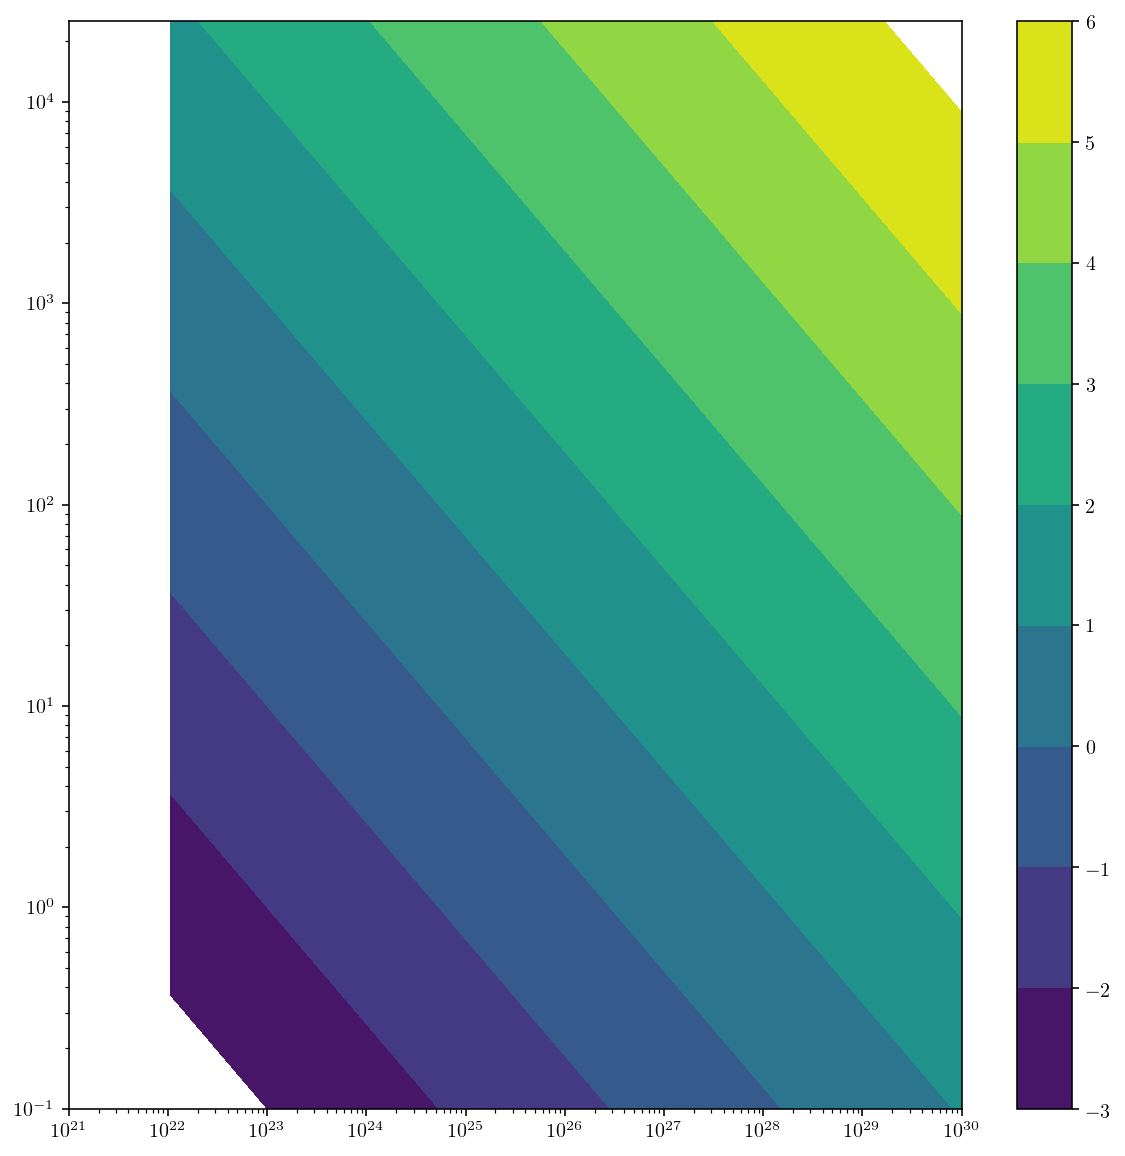

In [122]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

fig, ax = plt.subplots()

# contours for best possible ga
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(gr.pre_tpk_Gr))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(sn_Gr))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(echo_Gr))
cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, log10(time_Gr), levels=np.linspace(-3, 6, 10))
# cs = ax.contourf(gr.pre_Lpk_arr, gr.pre_tpk_arr, short_age)

fig.colorbar(cs)

plt.xscale("log"),plt.yscale("log");

0.58 3.34035167771


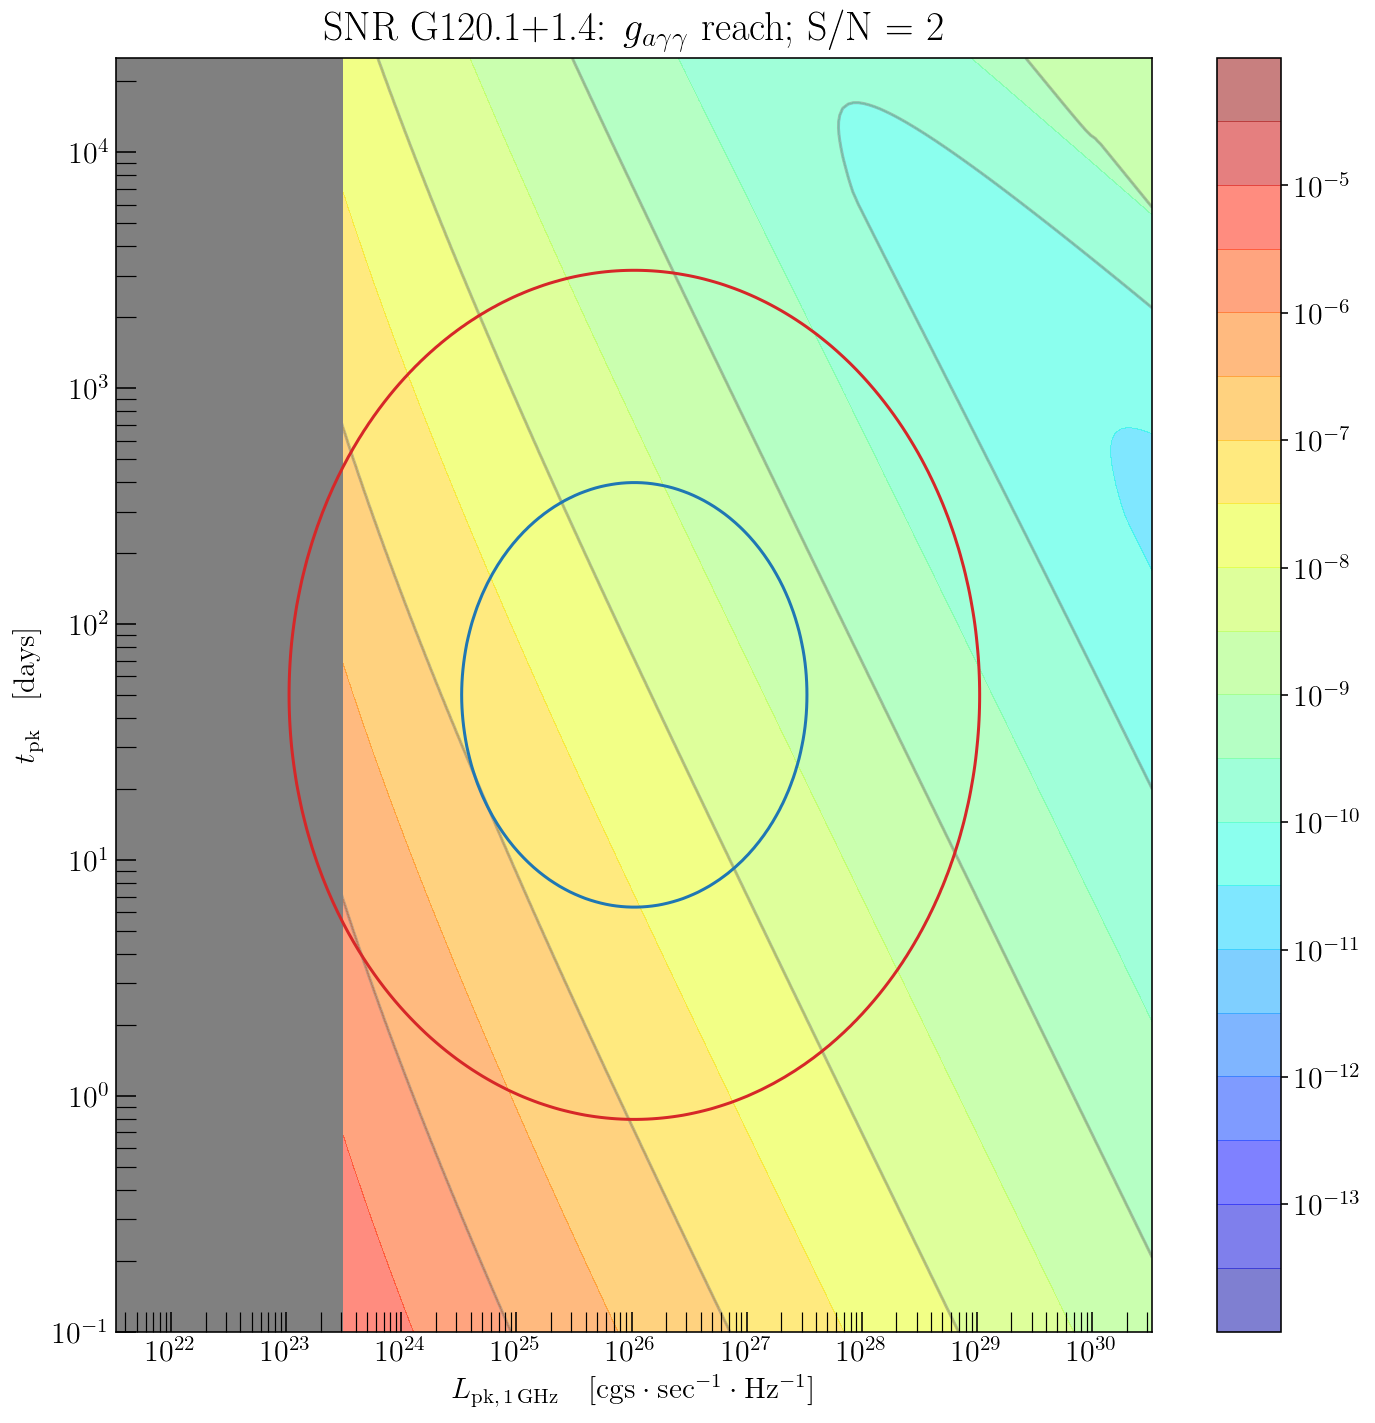

In [124]:
# figure properties
title_sz = 20.
label_sz = 15.
legend_sz = 15.
rcParams['figure.figsize'] = (10, 10)

fig, ax = plt.subplots()

ga_lvls = 10**np.arange(-14., -3.5, 0.5) # axion photon coupling levels
from_Bieten_to_pivot = (nu_pivot/nuB)**-snr.alpha
print snr.alpha, from_Bieten_to_pivot

tpk_arr = np.copy(gr.pre_tpk_arr)
new_Lpk_arr = np.copy(gr.pre_Lpk_arr)*from_Bieten_to_pivot # to plot w/ Lpk @ 1GHz

# contours for best possible ga
cs = ax.contourf(new_Lpk_arr, tpk_arr, ga_Gr, cmap="jet", levels=ga_lvls, alpha=0.5, zorder=-2, locator=ticker.LogLocator())
ax.contour(new_Lpk_arr, tpk_arr, ga_Gr, colors="grey", levels=np.logspace(-13, -5, 9), alpha=0.5, zorder=-2, locator=ticker.LogLocator())
ax.contourf(new_Lpk_arr, tpk_arr, no_Gr, levels=[0.9999, 1.0001], colors=['grey'], alpha=1., zorder=-1)

cbar = fig.colorbar(cs, ticks=np.logspace(-13, -5, 9))
cbar.ax.tick_params(labelsize=label_sz)

# exploration plots:
# ax.scatter(pars_sigs[name]['Lpk']*from_Bieten_to_pivot, pars_sigs[name]['tpk'], s=300., zorder=10., marker='*', color="C2")
# ax.contourf(new_Lpk_arr, tpk_arr, log10(ga_Gr), levels=[log10(ga_cast), 100.], colors=['indigo'], alpha=0.2, zorder=-1)
# ax.contourf(new_Lpk_arr, tpk_arr, no_Gr, levels=[0.9999, 1.0001], colors=['k'], alpha=0.4, zorder=-1)
# ax.contourf(new_Lpk_arr, tpk_arr, short_age, levels=[0.9999, 1.0001], colors=['r'], alpha=0.4, zorder=-1)
ax.contour(new_Lpk_arr, tpk_arr, gr.sigs_Gr, levels=[1., 2.], colors=['C0', 'C3'], linestyles=['-', '-'])

ax.set_title("SNR "+name+r": $g_{a\gamma\gamma}$ reach; S/N = "+str(int(sn_th)), fontsize=title_sz)
ax.set_ylabel(r"$t_{\rm pk}\quad[\mathrm{days}]$", fontsize=label_sz);
ax.set_xlabel(r"$L_{\rm pk, \, 1\,GHz}\quad[\mathrm{cgs \cdot sec^{-1} \cdot Hz^{-1}}]$", fontsize=label_sz);
ax.set_xscale("log");ax.set_yscale("log");
ax.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.)

folder = "./plots/"
filename = name+"_r-{}_1GHz.pdf".format(int(r))

plt.tight_layout()
# plt.savefig(folder+filename, bbox_inches="tight")

In [ ]:
0.64 3.7842305869
0.77 4.95883079976
0.58 3.34035167771

In [74]:
# ma-ga
Lpk = pars_sigs[name]['Lpk']*from_Bieten_to_pivot
tpk = pars_sigs[name]['tpk']
L0 = snr.get_luminosity()
gamma = ap.gamma_from_alpha(snr.alpha)

light_curve_params = {'L_peak':Lpk,
                      't_peak':tpk,
                      'L_today':L0}

if r != None:
    t_trans = r*(tpk/365.)
    light_curve_params.update({'t_trans':t_trans})
    t_age = ap.tage_compute(Lpk, tpk, t_trans, L0, gamma)
else:
    t_age = snr.age
    light_curve_params.update({'t_age':t_age})


age_steps = int(1000.*(log10(t_age) - log10(tpk/365.)) + 1)
max_steps = 100001
snu_echo_kwargs = {'tmin_default': None,
                   'Nt': min(age_steps, max_steps),
                   'xmin': ct._au_over_kpc_,
                   'xmax_default': 100.,
                   'use_quad': False,
                   'lin_space': False,
                   'Nint': min(age_steps, max_steps),
                   't_extra_old': tex}
            
# data:
data = {'deltaE_over_E': 1.e-3,
        'f_Delta': 0.721,
        'exper': 'SKA',
        'total_observing_time': 100.,
        'verbose': 0,
        'DM_profile': 'NFW',
        'average': True}


nu_arr = np.concatenate((np.logspace(log10(ct._nu_min_ska_low_), log10(ct._nu_max_ska_low_), 101), np.logspace(log10(ct._nu_min_ska_mid_), log10(ct._nu_max_ska_mid_), 101)))
ma_arr = pt.ma_from_nu(nu_arr)

z, new_output = md.snr_routine(ma_arr, ga_ref,
                               snr,
                               gamma=gamma,
                               nu_pivot=nu_pivot,
                               lightcurve_params=light_curve_params,
                               snu_echo_kwargs=snu_echo_kwargs,
                               data=data,
                               output_all=True,
                               verbose=0)

ma_ga = ec.ma_ga_bound(2., ma_arr, z, ga_ref)

../echo.py:1268: RuntimeWarning: divide by zero encountered in true_divide
  return ga_ref * sqrt(sn_val/sn_ref)


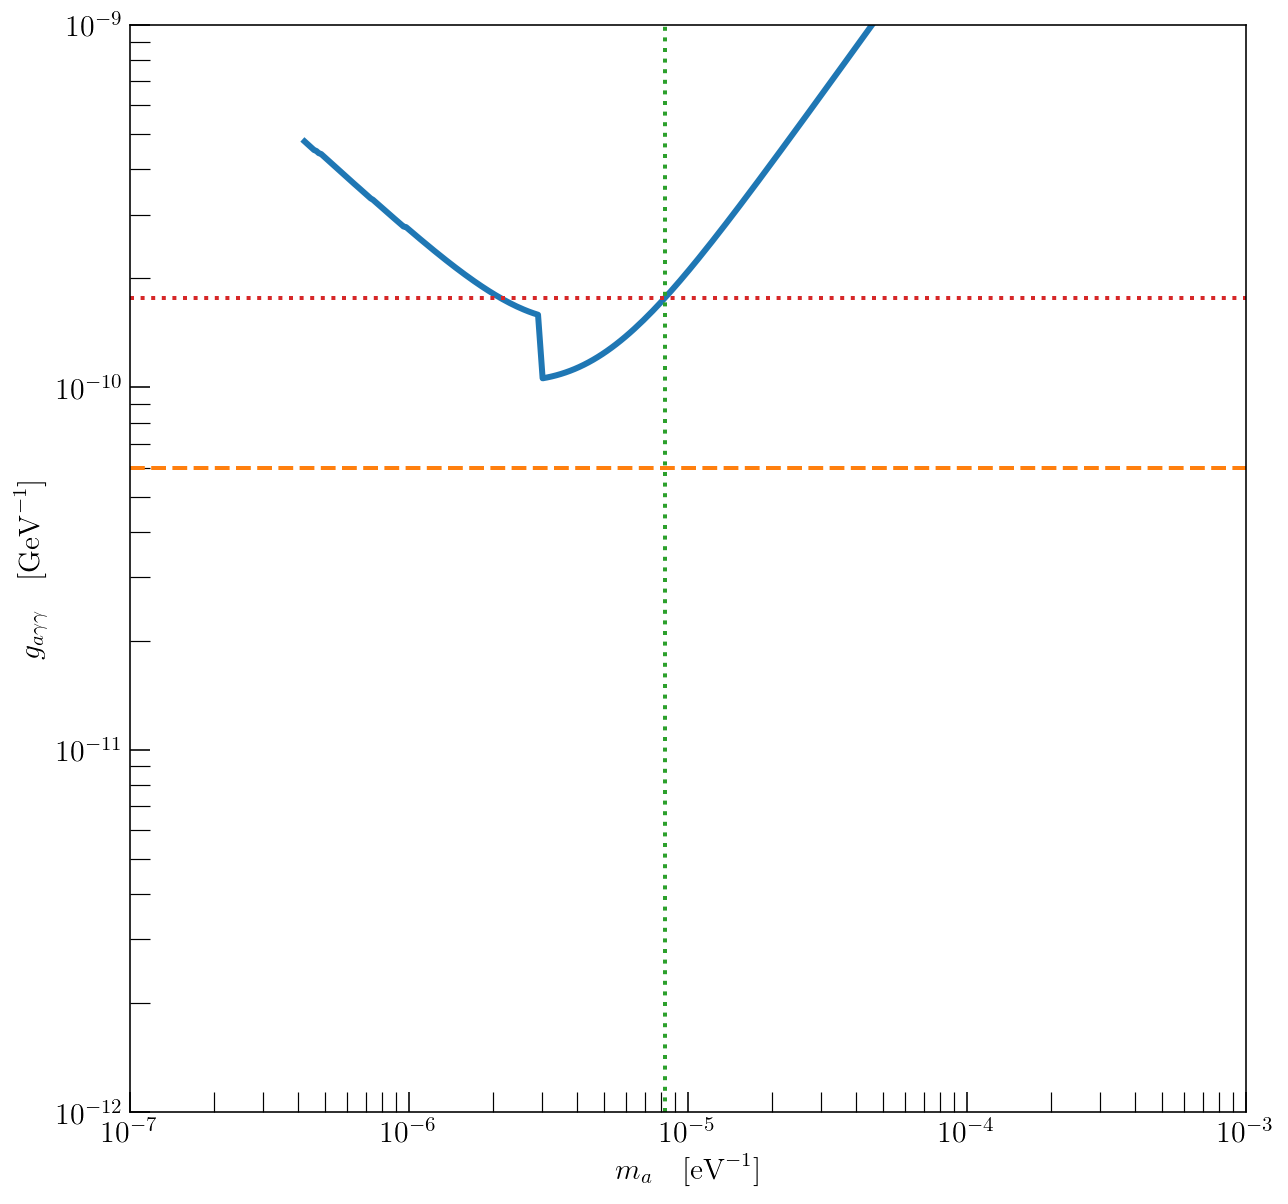

In [28]:
plt.loglog(ma_ga[:,0], ma_ga[:,1], lw=3., color='C0')
plt.axhline(ga_cast, lw=2., color='C1', ls="--")
plt.axvline(pt.ma_from_nu(1.), lw=2., color="C2", ls=":")
plt.axhline(min_ga_sigs[name], lw=2., color='C3', ls=":")

# plt.title(title, fontsize=title_sz);
plt.ylabel(r"$g_{a\gamma\gamma}\quad[\mathrm{GeV}^{-1}]$", fontsize=label_sz);
plt.xlabel(r"$m_a\quad[\mathrm{eV}^{-1}]$", fontsize=label_sz);
plt.tick_params("both", which="both", labelsize=label_sz, direction="in", length=10.);

plt.xlim(1.e-7, 1.e-3);plt.ylim(1.e-12, 1.e-9);
# plt.savefig(file_name, bbox_inches="tight")